### Load neccessary packages

In [1]:
import tensorflow as tf
import keras_core as keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

tf.__version__, keras.__version__

Using TensorFlow backend


('2.14.0', '0.1.7')

In [12]:
# Load TFLite model and allocate tensors.
with open("./age_detection.tflite", 'rb') as f:
    model = tf.lite.Interpreter(model_content=f.read())
    model.allocate_tensors()

# Print the signatures
signatures = model.get_signature_list()
print(signatures)

# We would use this index to assign input tensor, process and get the output prediction
input_index = model.get_input_details()[0]['index']
output_index = model.get_output_details()[0]['index']

input_index, output_index

{'serving_default': {'inputs': ['inputs'], 'outputs': ['output_0']}}


(0, 222)

### Defining helper utilities

In [14]:
def detect_age(x, input_index=input_index, output_index=output_index):
    model.set_tensor(input_index, x)
    model.invoke()
    return model.get_tensor(output_index)[0][0]

In [16]:
haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') 
detect_face = lambda x: haar_cascade.detectMultiScale(x, scaleFactor=1.1, minNeighbors=9) 

In [33]:
def annotate_frame_with_age(image, detect_face=detect_face, detect_age=detect_age):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    faces_rect = detect_face(gray_img)

    for (x, y, w, h) in faces_rect: 
        temp = image[y:y+h, x:x+w]
        temp = keras.ops.image.resize(temp, size=(128, 128))
        temp = keras.ops.cast(temp, 'float32')
        temp = keras.ops.expand_dims(temp, axis=0) / 255.
        age = detect_age(temp)
        age_str = str(int(age))
        cv2.putText(image, age_str, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), thickness=2) 

    return image

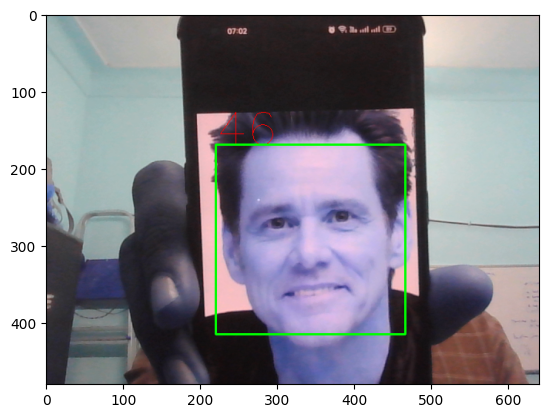

In [45]:
camera = cv2.VideoCapture(0)
ret, frame = camera.read()
camera.release()

plt.imshow(annotate_frame_with_age(frame, detect_age=detect_age, detect_face=detect_face));

In [46]:
from IPython.display import display, Image

video = cv2.VideoCapture(0)
display_handle=display(None, display_id=True)
try:
    while True:
        _, frame = video.read()
        frame = cv2.flip(frame, 1) # if your camera reverses your image
        frame = annotate_frame_with_age(frame, detect_age=detect_age, detect_face=detect_face)
        _, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

None